### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions as dist
from torchsummary import summary
import math
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import re
from skimage.metrics  import structural_similarity as ssim

from importlib import reload
import visualization

# locals
import model_architectures_2d

reload(model_architectures_2d)
from model_architectures_2d import DataSeg2Seg, UNet, MiniUNet, MinierUNet, DataSeg2SegUnbatched

reload(visualization)
from visualization import brain_diff, viz_slices

C:\compute\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Paths

In [2]:
research_dir = r"D:/school/research"
code_dir = os.path.join(research_dir, "code")
model_dir = os.path.join(code_dir, "explore_again", "models")
data_dir = os.path.join(research_dir, "data")
dhcp_rel2 = os.path.join(data_dir, "dhcp_rel2")
processed_dir = os.path.join(dhcp_rel2, "processed")
volume_dir = os.path.join(processed_dir, "volumes")
seg_dir = os.path.join(processed_dir, "segments")
seg_vol_dir = os.path.join(processed_dir, "volume_segments")
pred_dir = os.path.join(dhcp_rel2, "predictions")
seg_pred_dir = os.path.join(pred_dir, "vae_9seg")

l1_dir = os.path.join(volume_dir, "l1")
l5_dir = os.path.join(volume_dir, "l5")

l1_seg_dir = os.path.join(seg_dir, "l1")
l5_seg_dir = os.path.join(seg_dir, "l5")

l1_seg_vol_dir = os.path.join(seg_vol_dir, "l1")
l5_seg_vol_dir = os.path.join(seg_vol_dir, "l5")

l1_seg_pred_dir = os.path.join(seg_pred_dir, "l1")
l5_seg_pred_dir = os.path.join(seg_pred_dir, "l5")

### Load Data

In [3]:
np.random.seed(42)
num_samples = int(len(os.listdir(l1_dir)) / 2)
samples = np.array([i for i in range(0, num_samples)])
np.random.shuffle(samples)

split_val = int(0.8 * num_samples)
train_indices = samples[0:split_val]
val_indices = samples[split_val:]

num_test = int(len(os.listdir(l5_dir)) / 2)
test_indices = np.array([i for i in range(0, num_test)])

In [4]:
bsize = 128
train = DataSeg2Seg(l1_seg_vol_dir, l1_seg_pred_dir, train_indices, seg_num=2, batch_size=bsize)
val = DataSeg2Seg(l1_seg_vol_dir, l1_seg_pred_dir, val_indices, seg_num=2, batch_size=bsize)
test = DataSeg2Seg(l5_seg_vol_dir, l5_seg_pred_dir, test_indices, seg_num=2, batch_size=bsize)

# batch_size = 1
# train_loader = DataLoader(train, batch_size=batch_size)#, num_workers=1)
# val_loader = DataLoader(val, batch_size=batch_size)#, num_workers=1)

### Train Model on Residual for Cortical Grey Matter (2)

In [5]:
### This initializes a minier unet with the ground truth in and out
model = MinierUNet(1)

model.cuda()
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-07)

num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(train, unit="batch", ascii=' >=') as tepoch:
        model.train()
        data_counter = 0
        for data in tepoch:
            for batch in data:
                optimizer.zero_grad()
                x, y = batch
                residual = y - x

                residual = torch.Tensor(residual).cuda()
                y = torch.Tensor(y).cuda()

                output = model(residual)
                loss = criterion(y, output)

                # backward
                loss.backward()
                optimizer.step()

                total_loss += loss.data
                data_counter += 1

        total_loss /= (data_counter)
        
        tepoch.set_postfix(loss=loss.item())
        val_loss = 0
        model.eval()
        data_counter = 0
        for data in val:
            for batch in data:
                with torch.no_grad():
                    x, y = batch
                    residual = y - x

                    residual = torch.Tensor(residual).cuda()
                    y = torch.Tensor(y).cuda()

                    output = model(residual)
                    loss = criterion(y, output)

                    val_loss += loss.data
                    data_counter += 1
        
        val_loss /= data_counter
        
        
        print('epoch [{}/{}], train_loss:{:.4f}, val_loss:{:.4f}'
              .format(epoch+1, num_epochs, total_loss, val_loss))

100%|=============================================================================| 166/166 [04:49<00:00,  1.74s/batch]


epoch [1/100], train_loss:0.0055, val_loss:0.0123


 52%|========================================                                      | 86/166 [02:44<02:33,  1.92s/batch]


KeyboardInterrupt: 

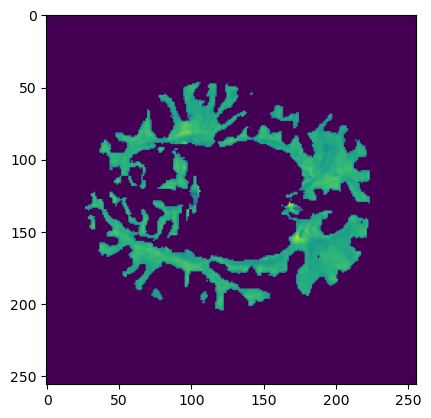

In [12]:
plt.imshow(np.reshape(x[128], (256, 256)))

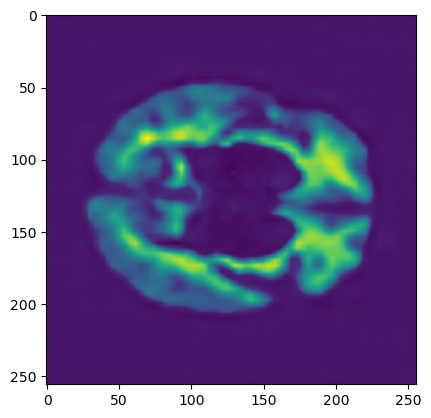

In [13]:
plt.imshow(np.reshape(y.detach().cpu().numpy()[128], (256, 256)))

### Visualize Train Results

D:\school\research\code\explore_again\modeling\vae\visualization.py:89: UserWarning: Trying to register the cmap 'above_mean' which already exists.
  plt.register_cmap(cmap=map_object)
D:\school\research\code\explore_again\modeling\vae\visualization.py:96: UserWarning: Trying to register the cmap 'below_mean' which already exists.
  plt.register_cmap(cmap=map_object)


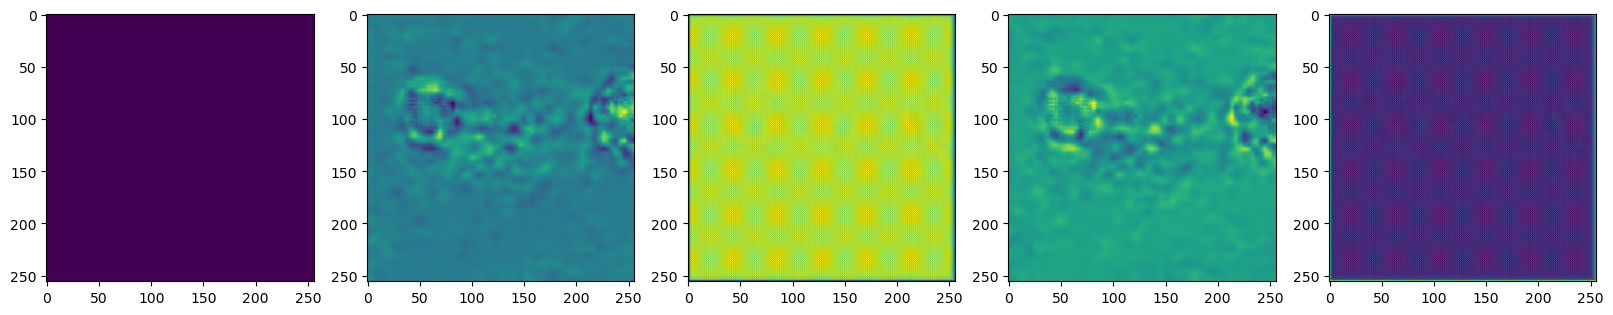

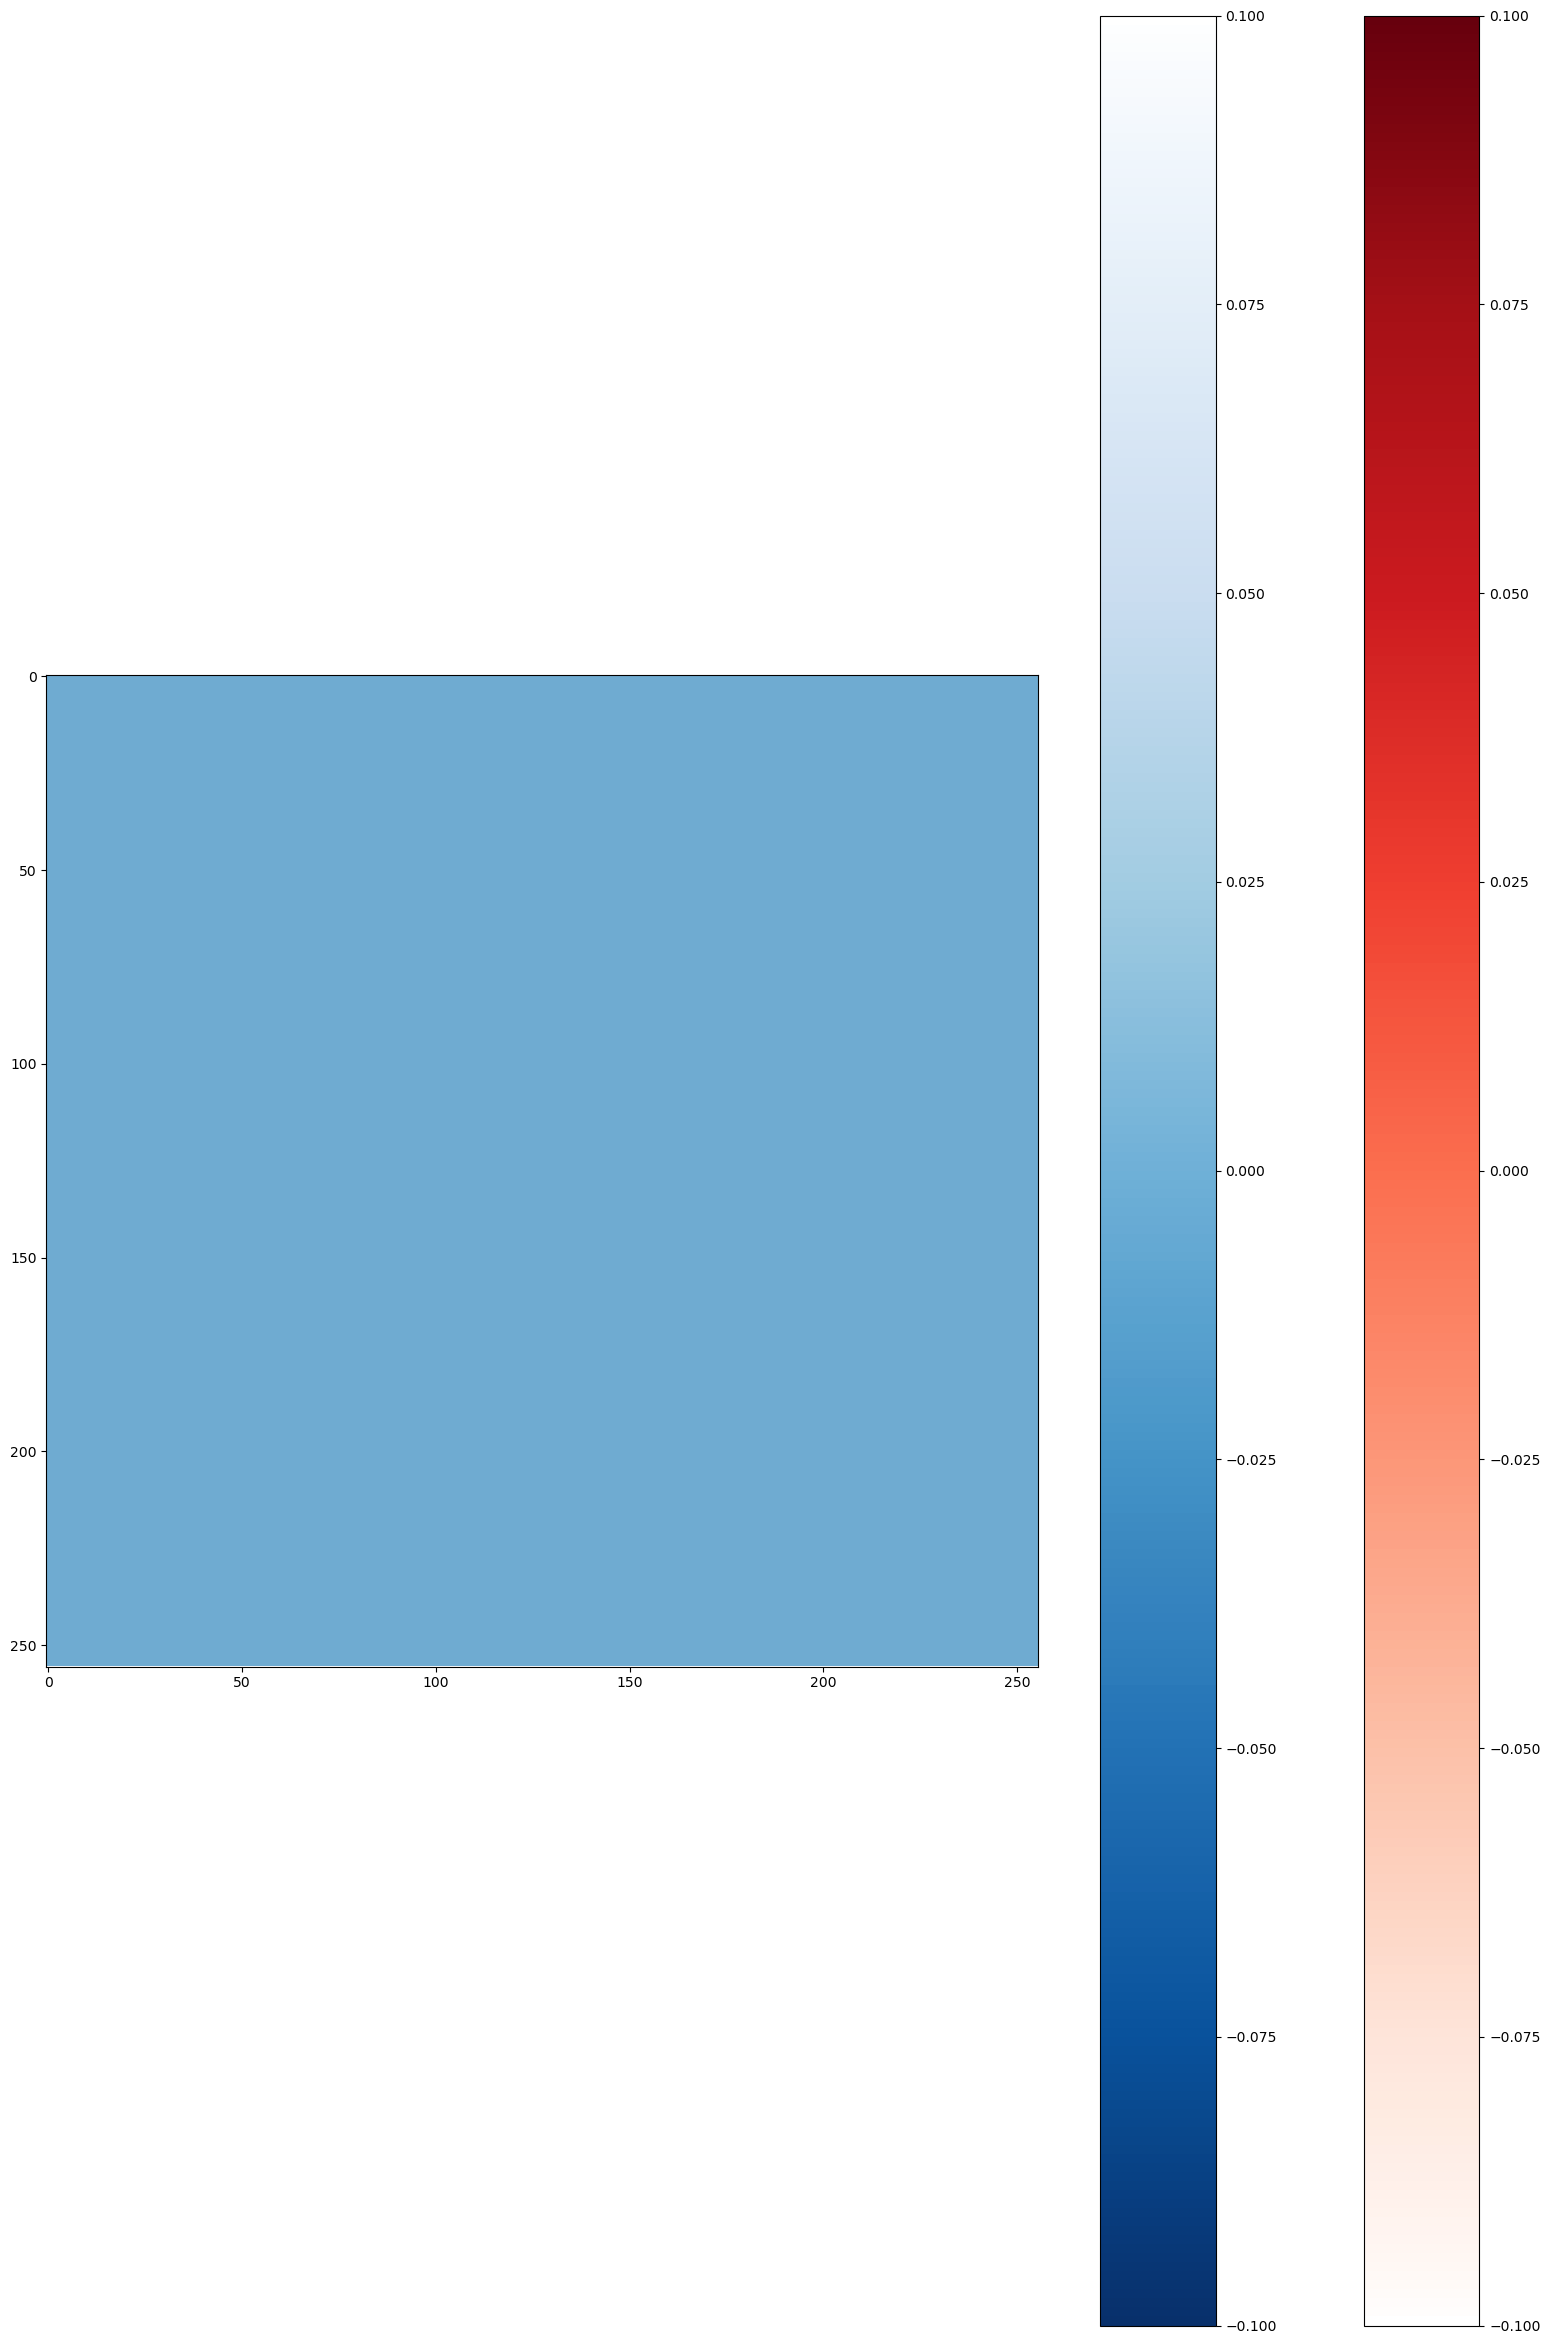

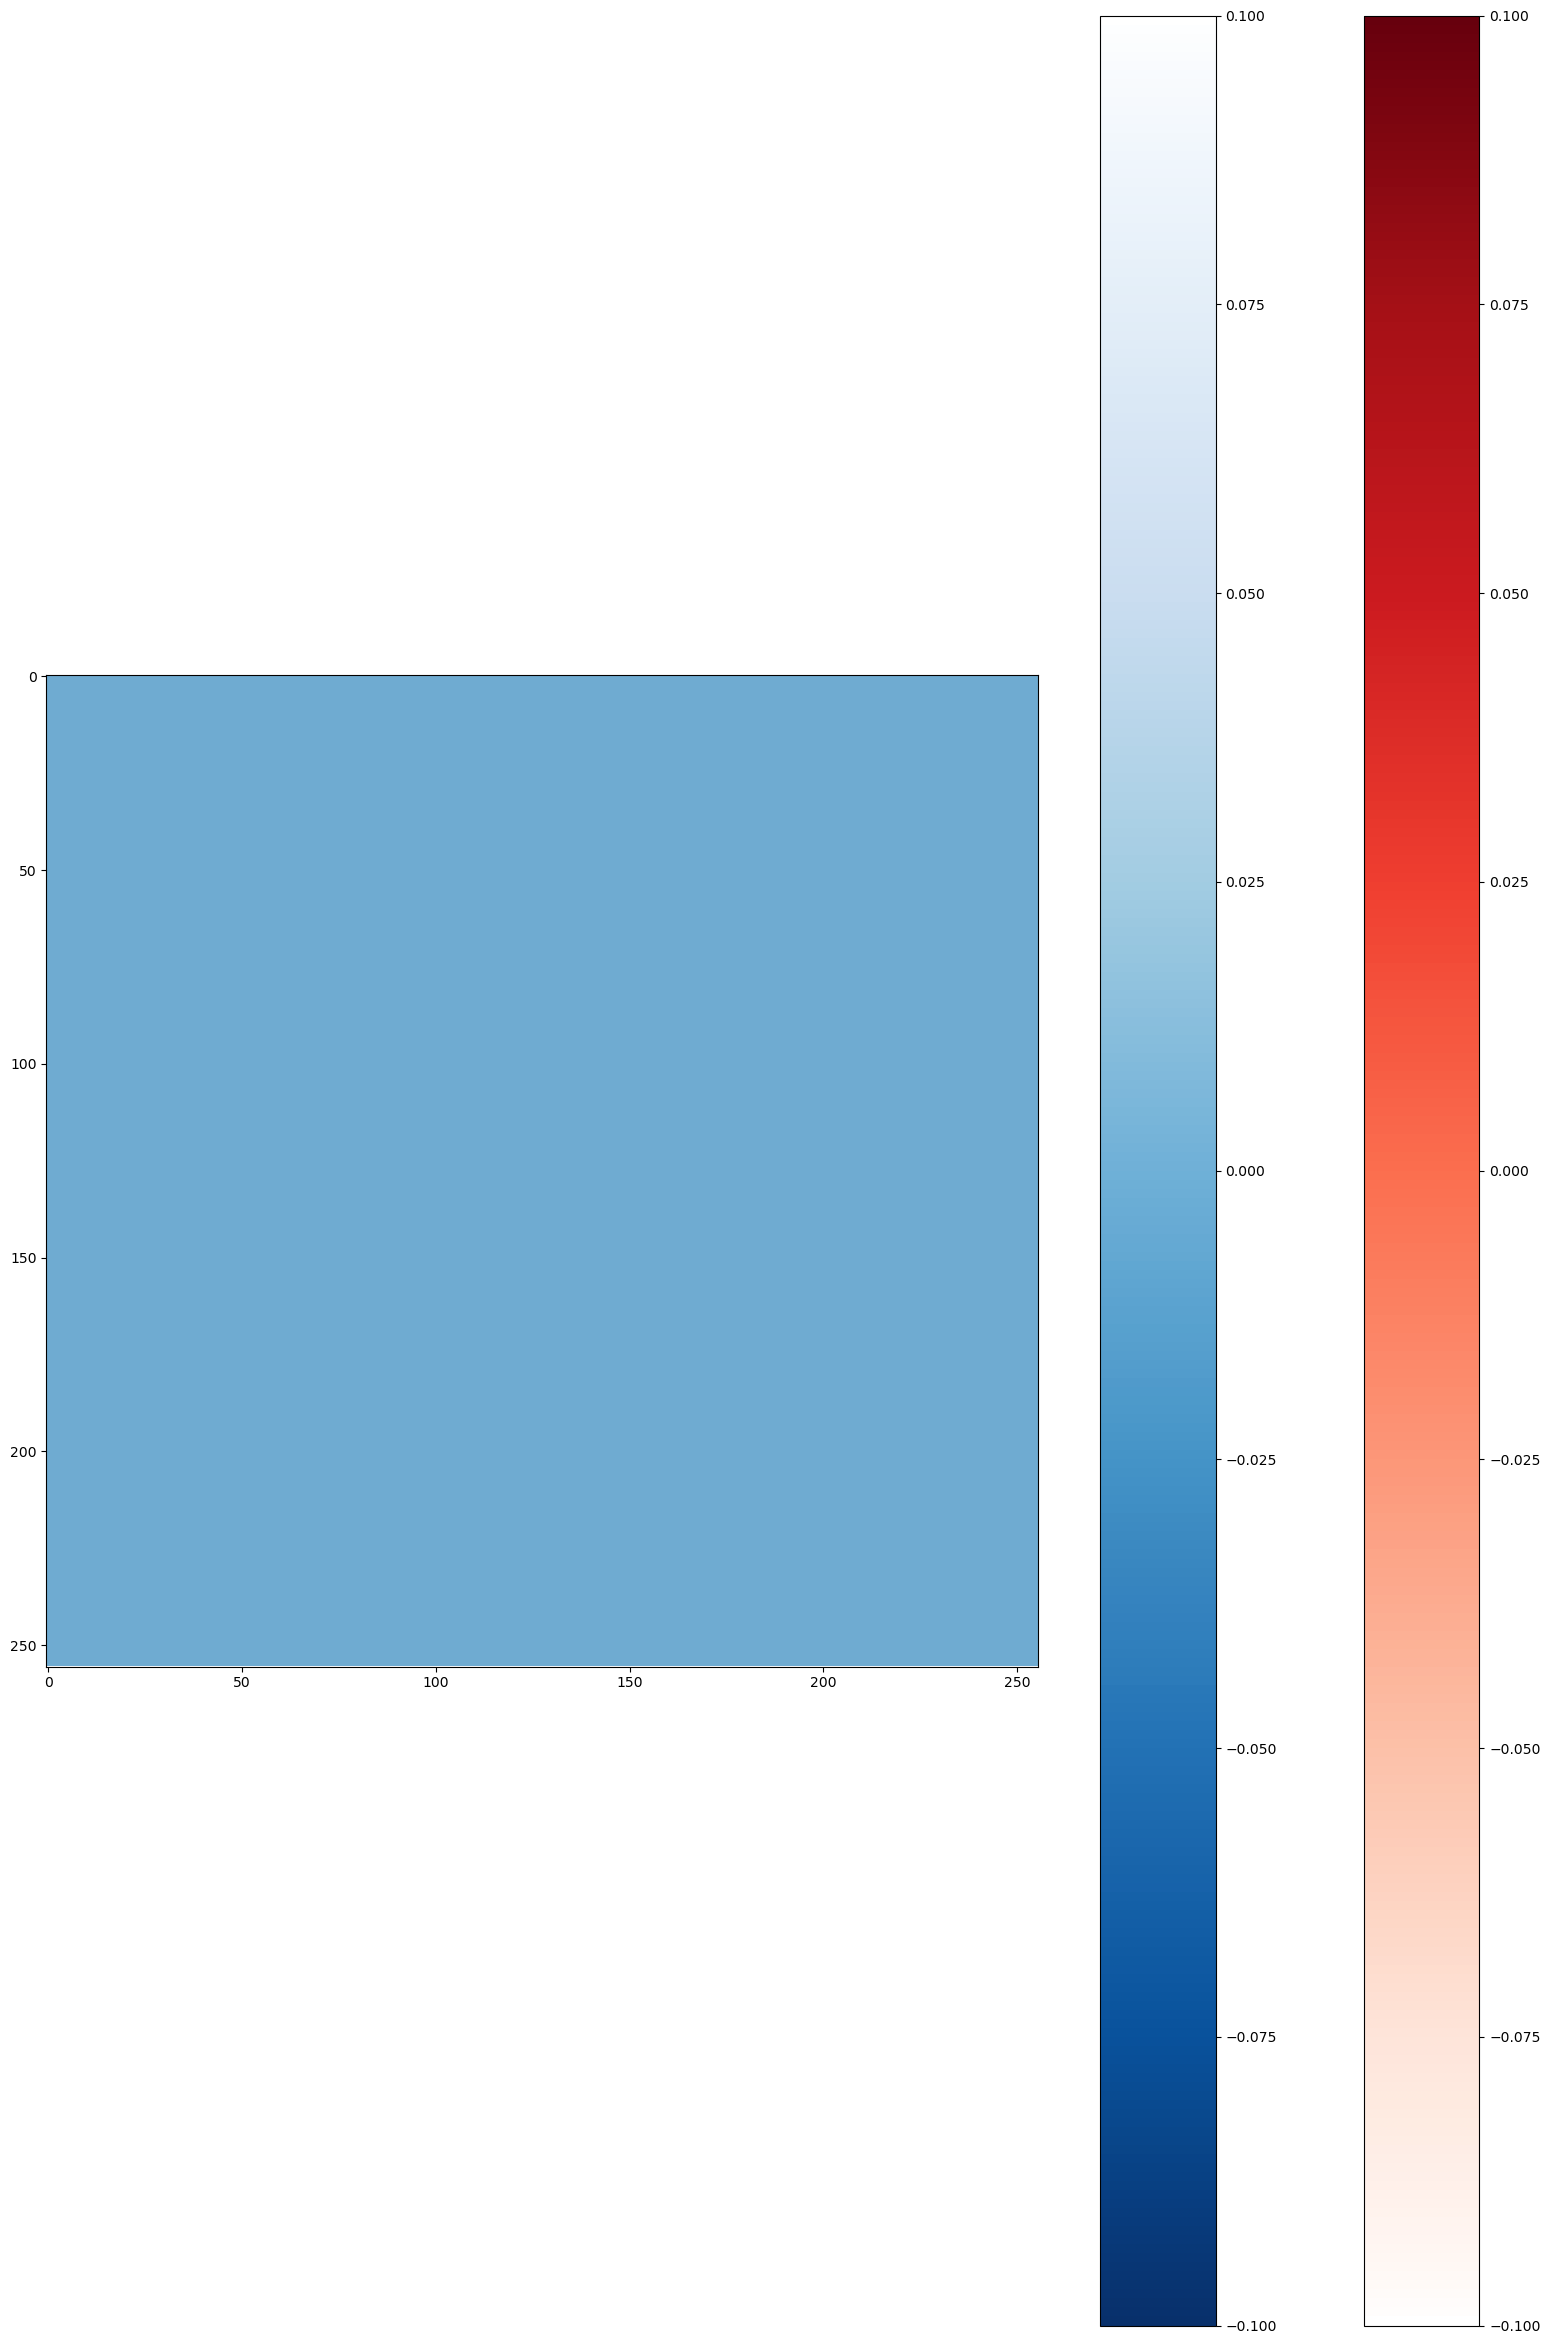

In [6]:
model.eval()
data = train[0]
y, x = data[1]
residual = y - x

residual = torch.Tensor(residual).cuda()
output = model(residual)

pred = np.reshape(output.detach().cpu().numpy()[-1], (256, 256))
seg = np.reshape(y[-1], (256, 256))
og = np.reshape(x[-1], (256, 256))

fig, ax = plt.subplots(1, 5, figsize=(20,20))

ax[0].imshow(og)
ax[1].imshow(seg)
ax[2].imshow(pred)
ax[3].imshow(og - seg)
ax[4].imshow(og - pred)

brain_diff(og, seg, threshold=2)
brain_diff(og, pred, threshold=2)

### Visualize Val Results

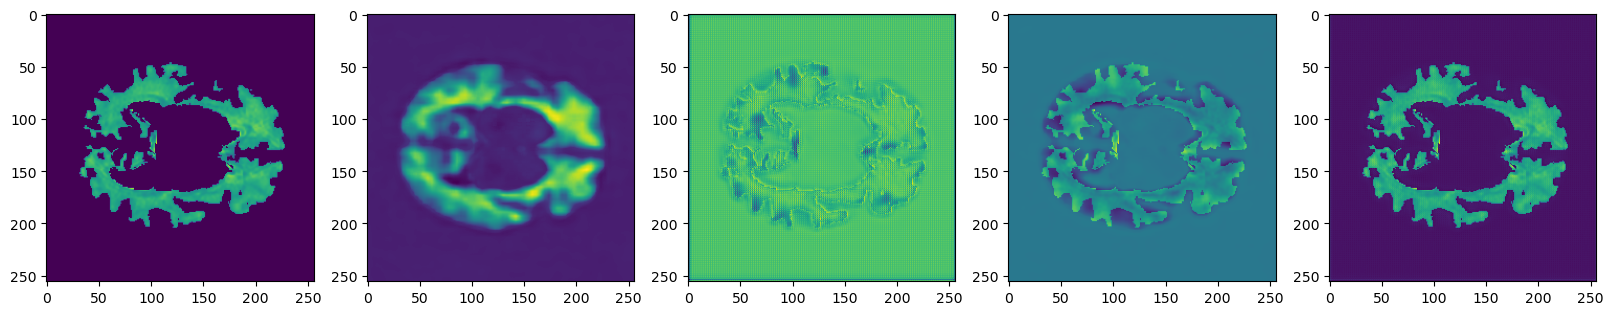

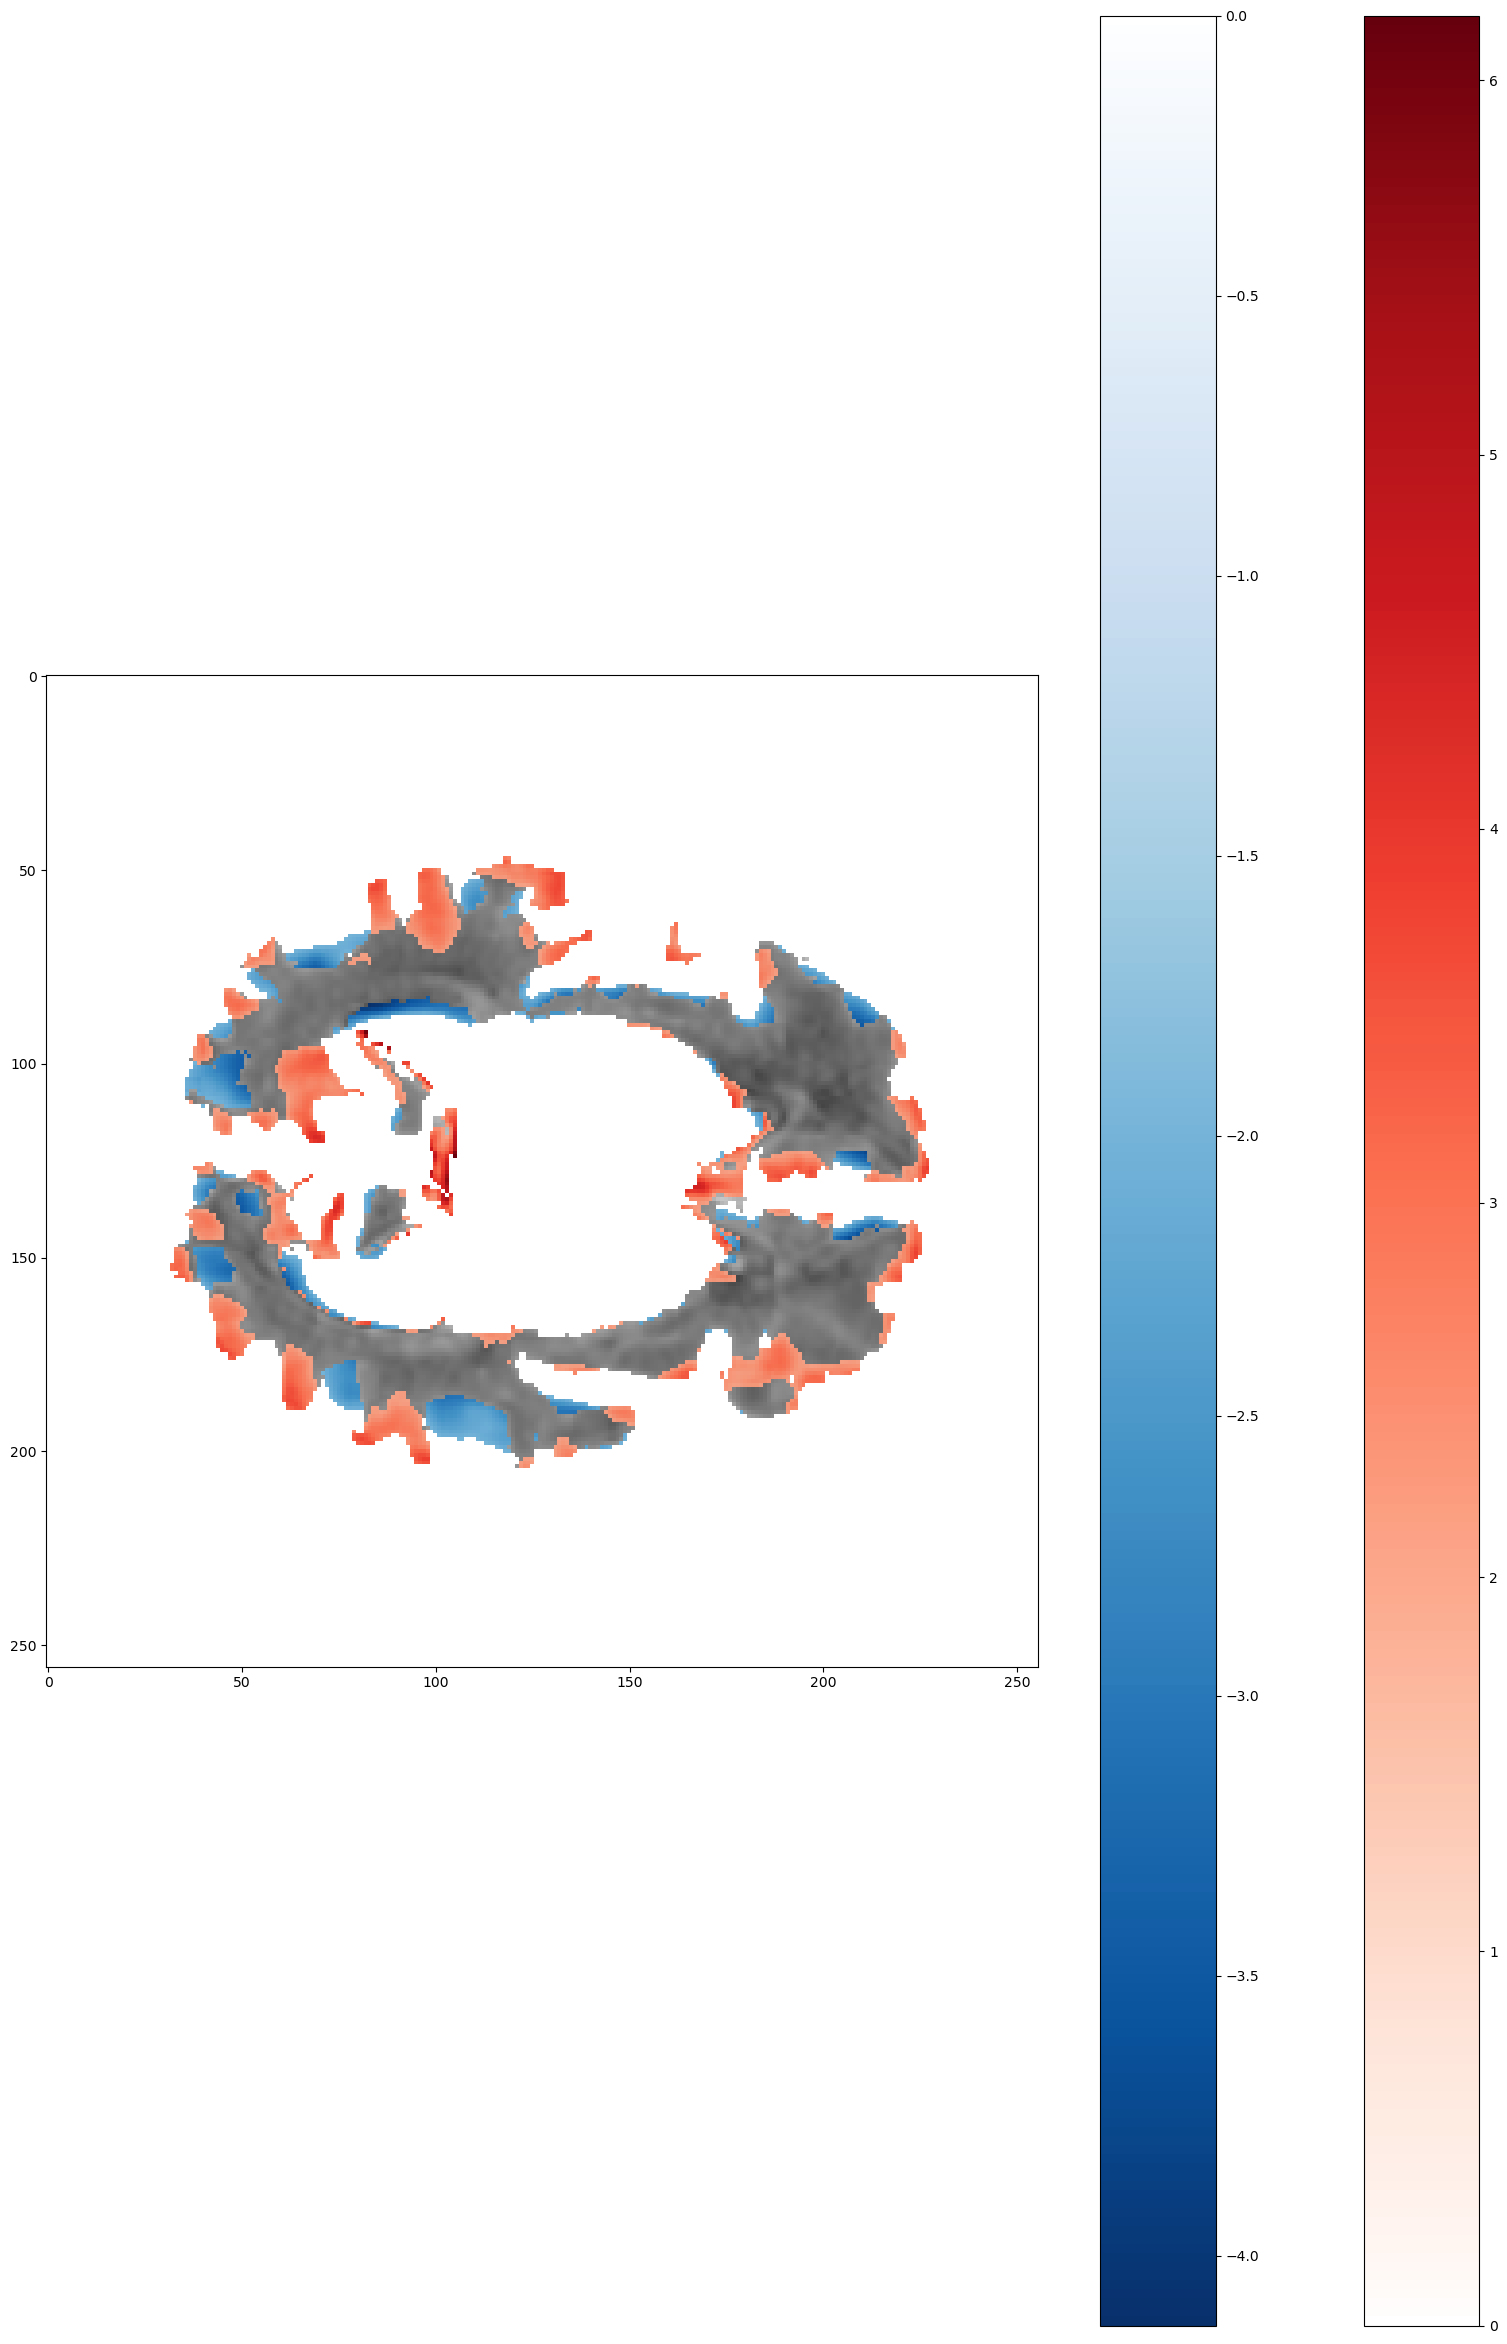

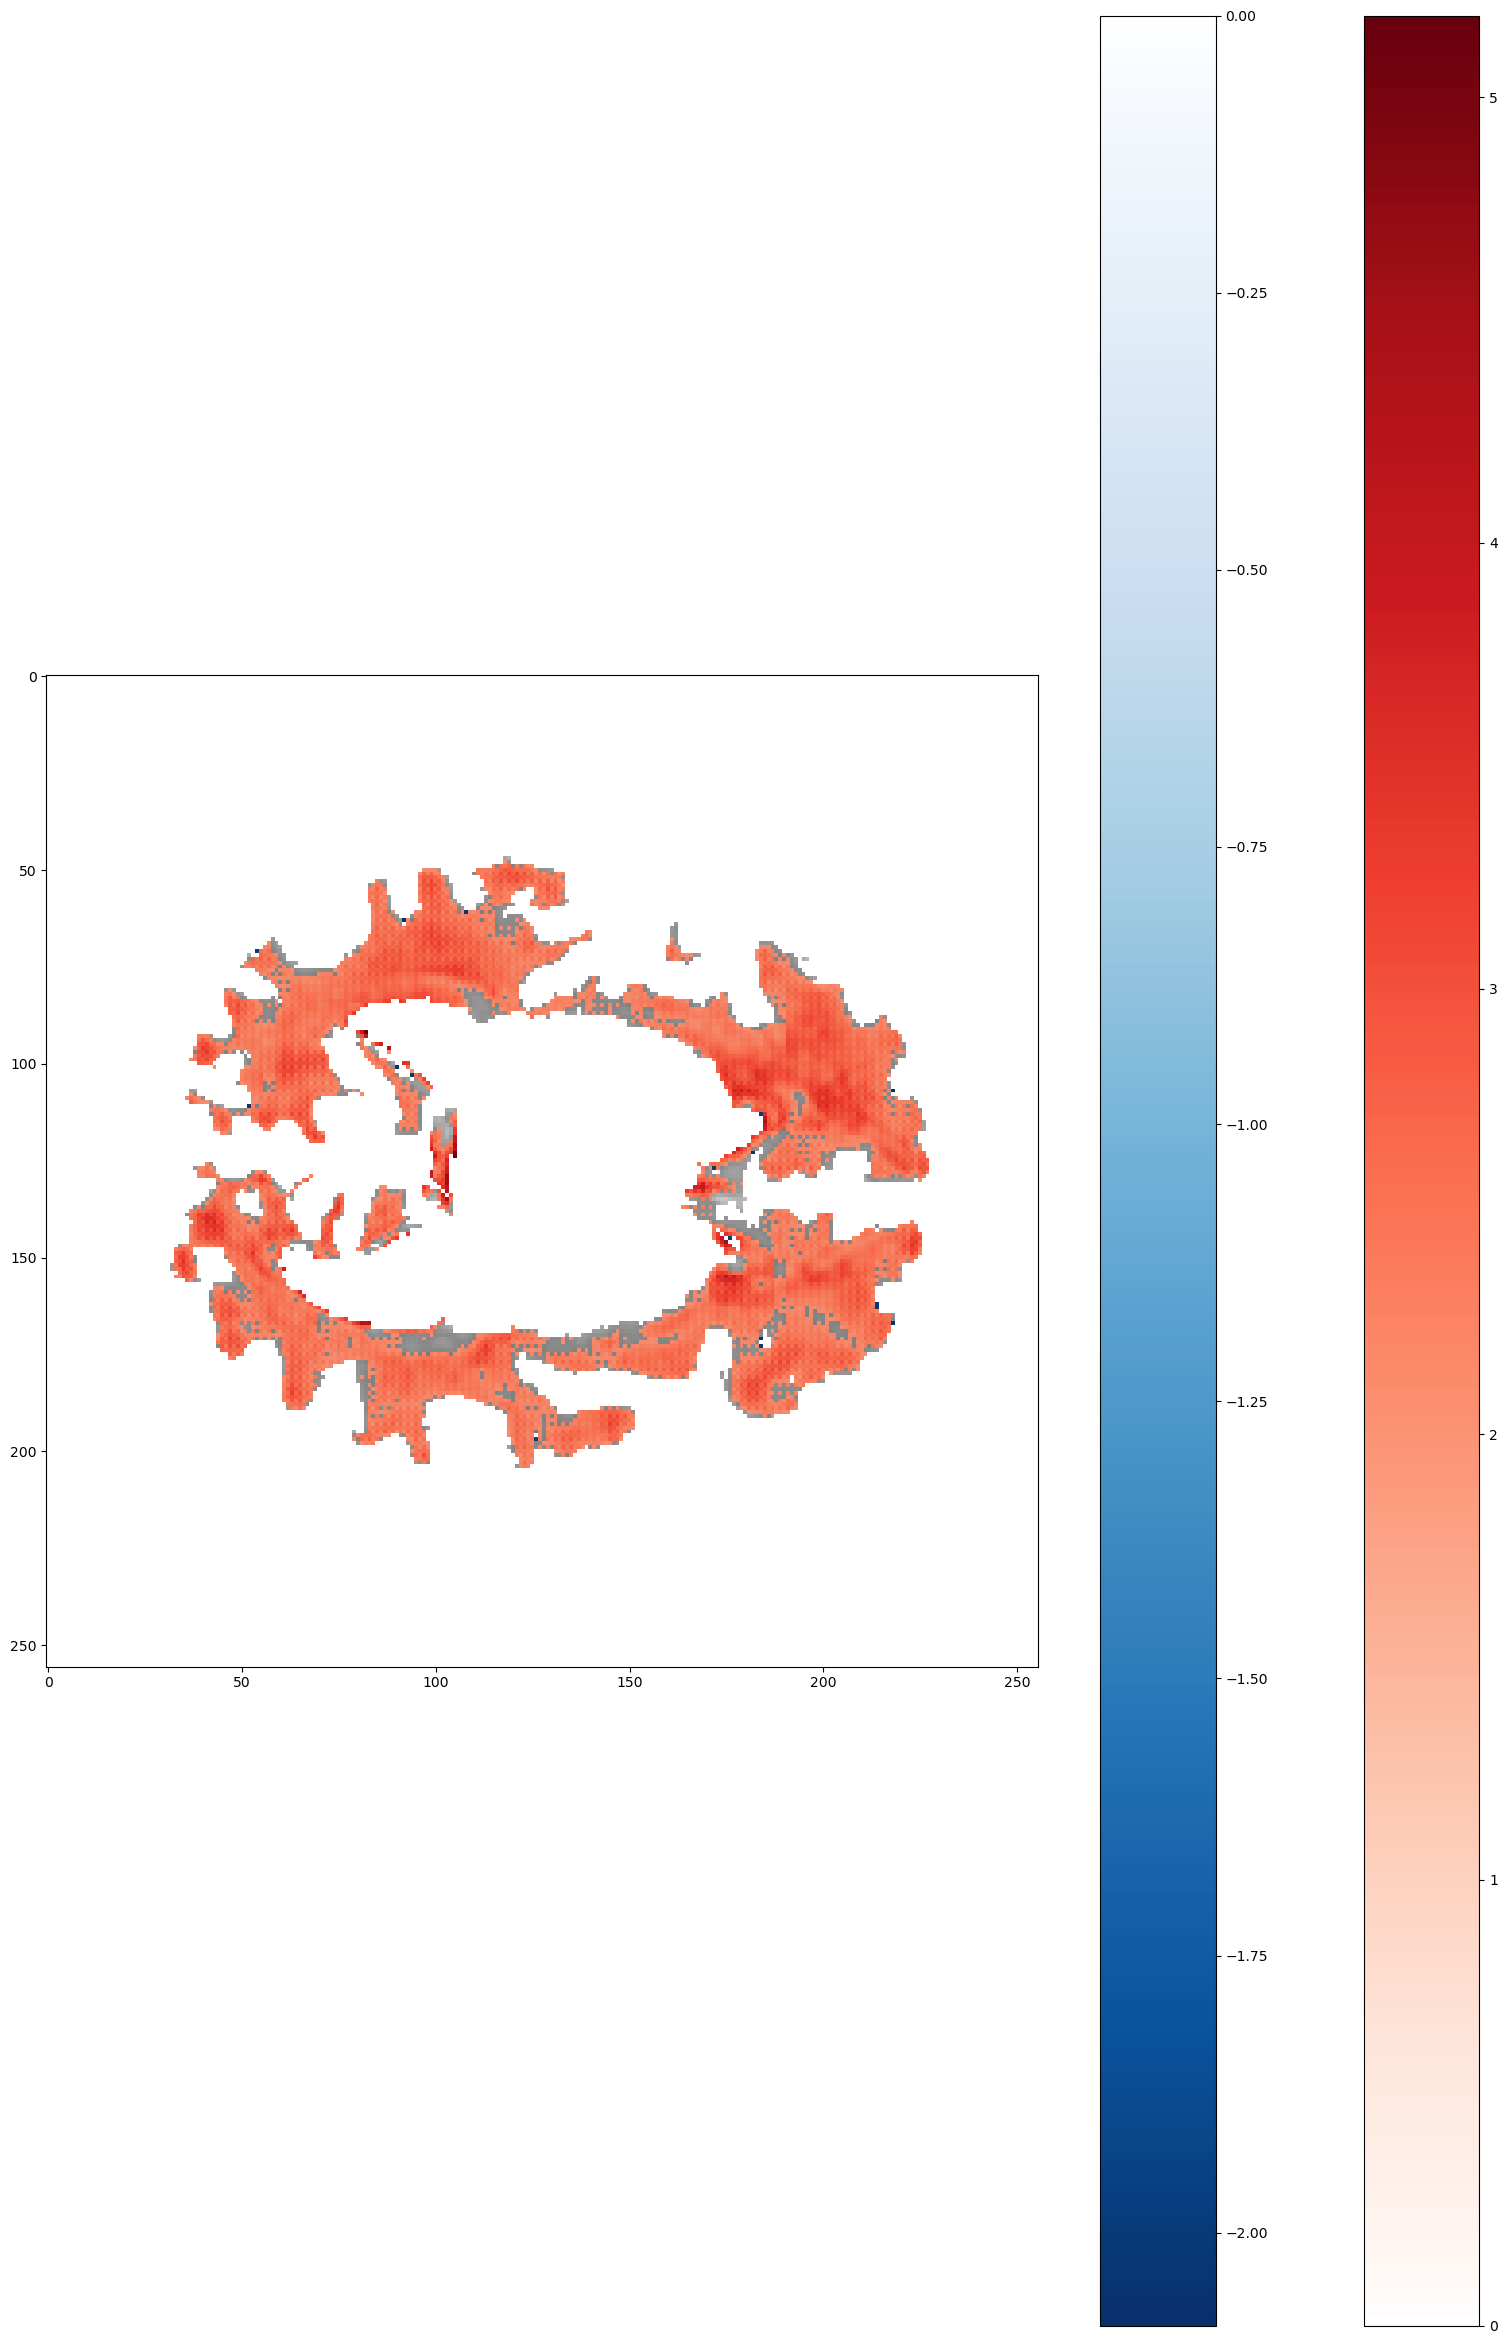

In [35]:
model.eval()
data = val[0]
y, x = data[1]
residual = y - x

residual = torch.Tensor(residual).cuda()
output = model(residual)

pred = np.reshape(output.detach().cpu().numpy()[-1], (256, 256))
seg = np.reshape(y[-1], (256, 256))
og = np.reshape(x[-1], (256, 256))

fig, ax = plt.subplots(1, 5, figsize=(20,20))

ax[0].imshow(og)
ax[1].imshow(seg)
ax[2].imshow(pred)
ax[3].imshow(og - seg)
ax[4].imshow(og - pred)

brain_diff(og, seg, threshold=2)
brain_diff(og, pred, threshold=2)

### Visualize Test Results

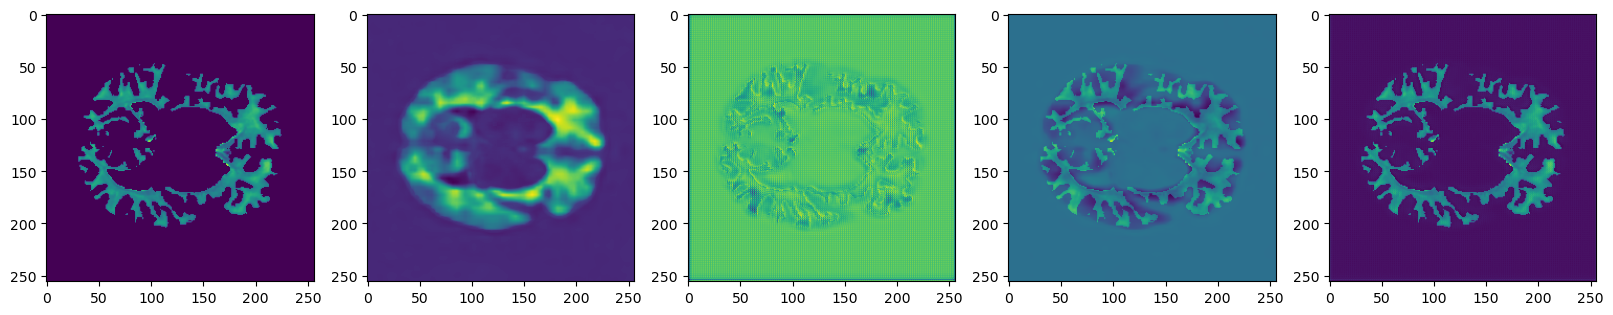

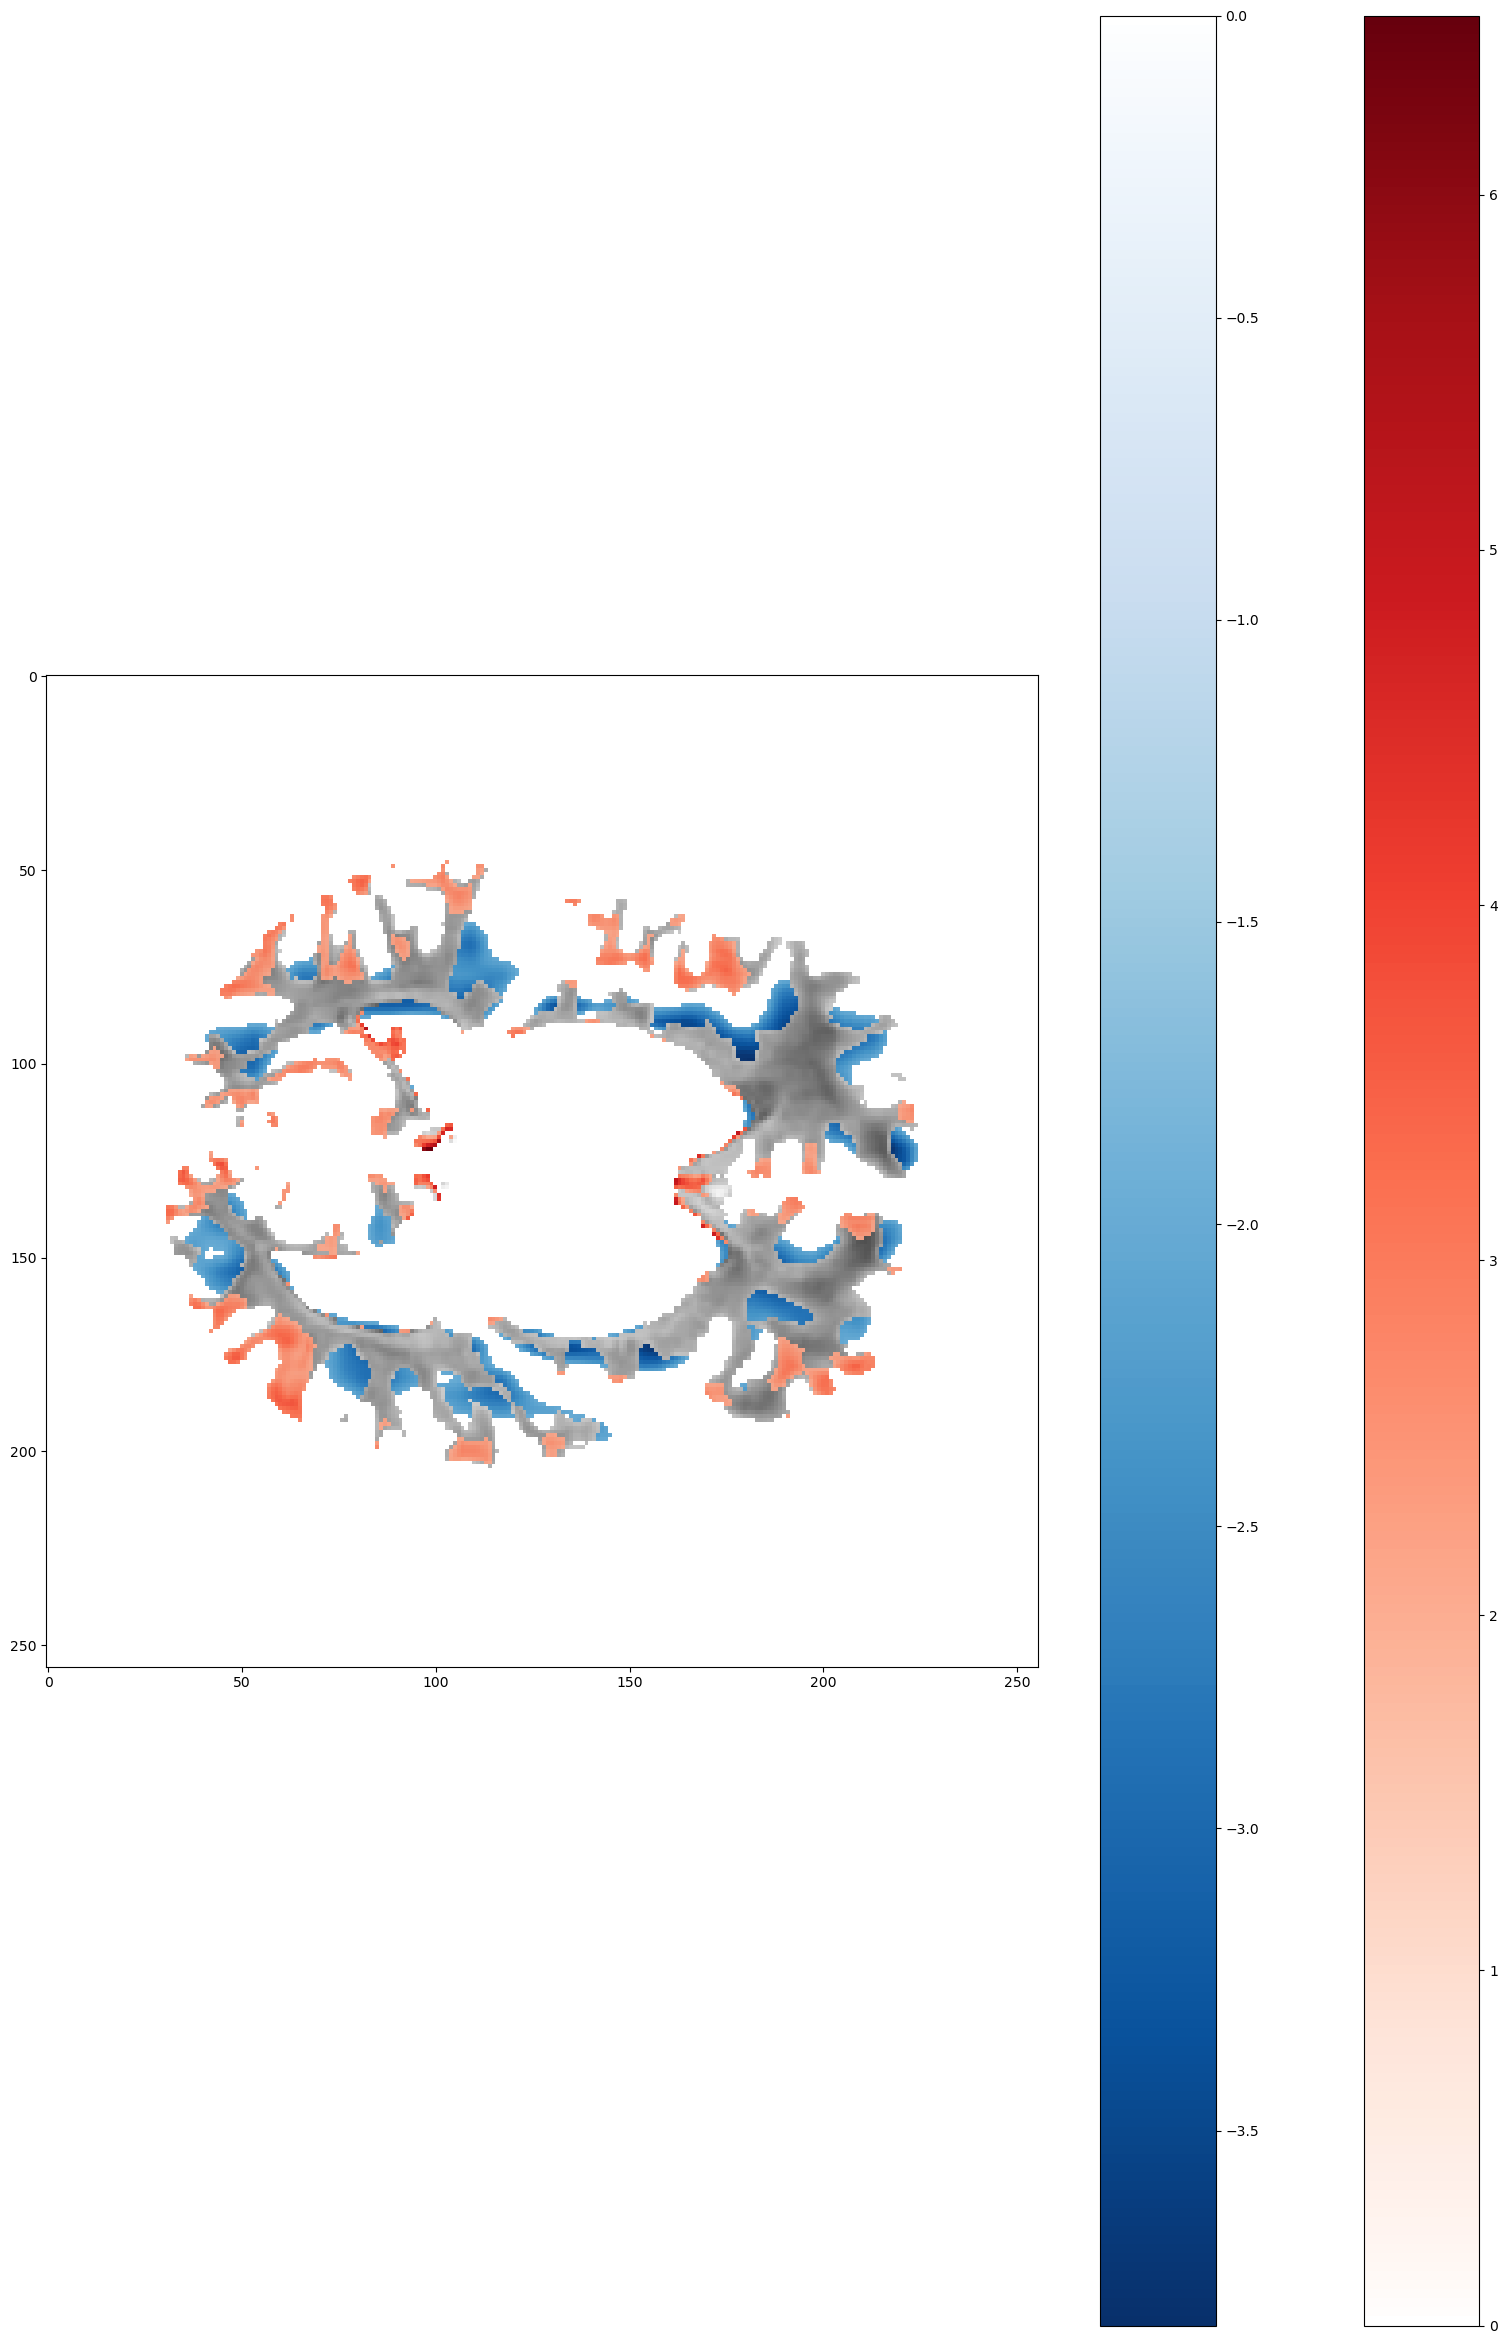

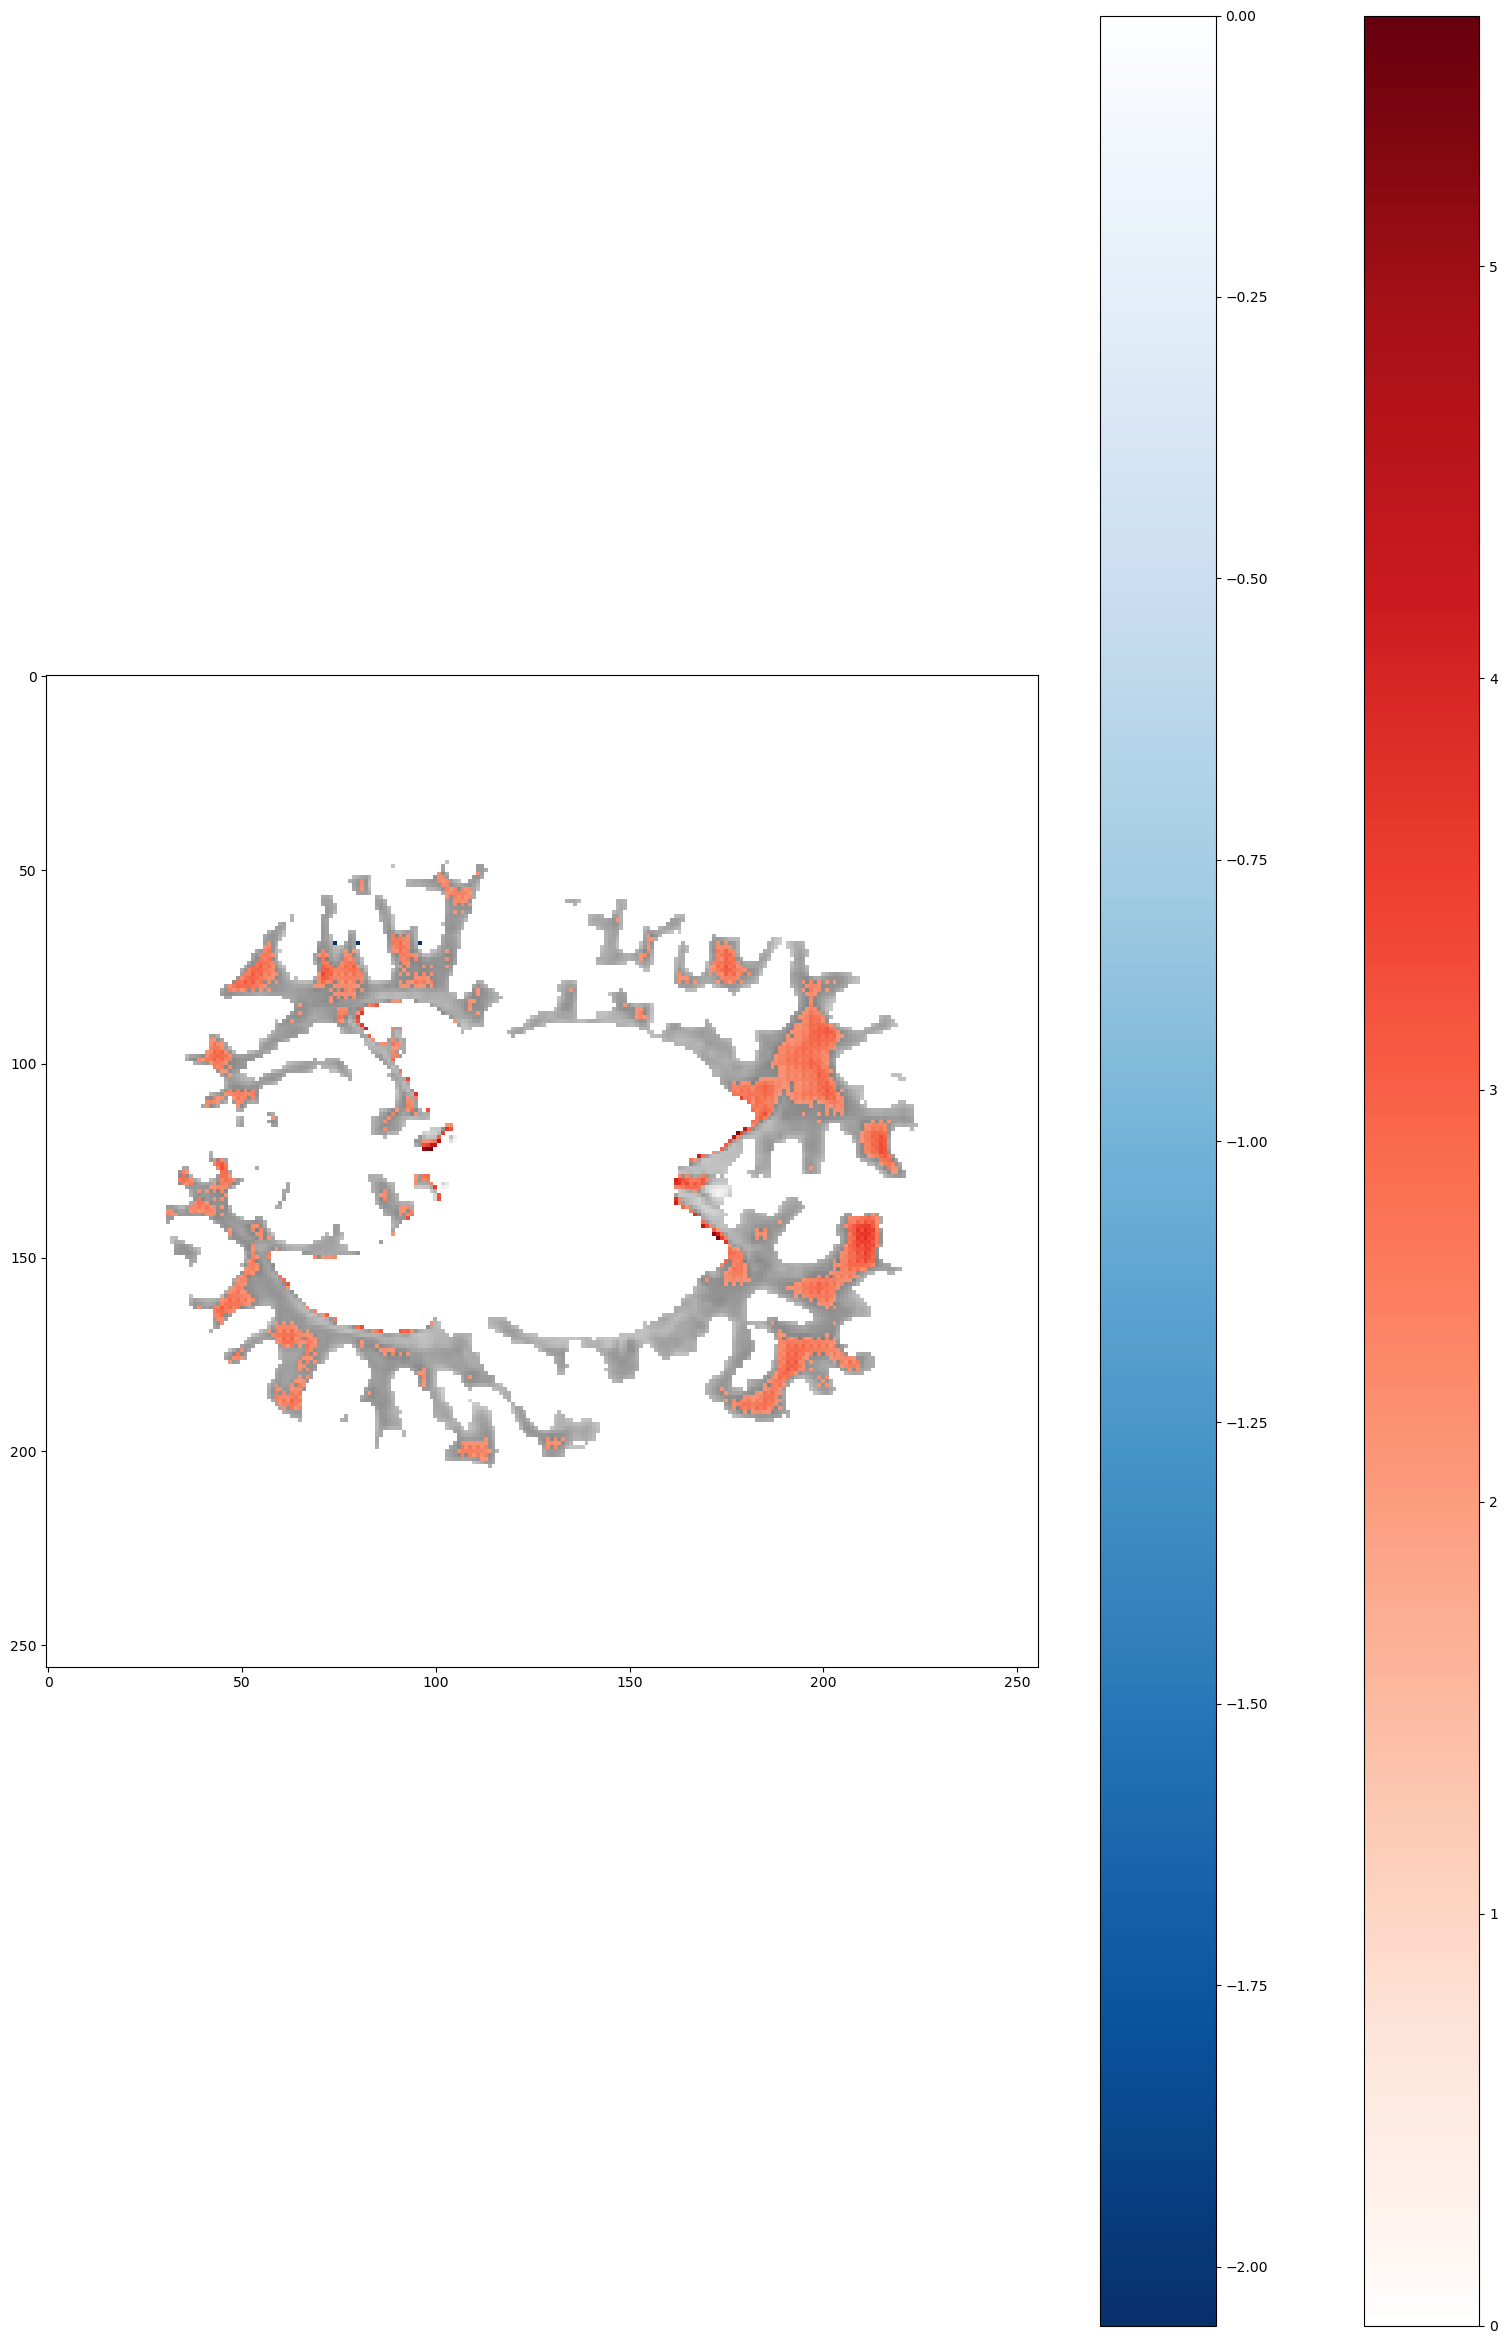

In [36]:
model.eval()
data = test[0]
y, x = data[1]
residual = y - x

residual = torch.Tensor(residual).cuda()
output = model(residual)

pred = np.reshape(output.detach().cpu().numpy()[-1], (256, 256))
seg = np.reshape(y[-1], (256, 256))
og = np.reshape(x[-1], (256, 256))

fig, ax = plt.subplots(1, 5, figsize=(20,20))

ax[0].imshow(og)
ax[1].imshow(seg)
ax[2].imshow(pred)
ax[3].imshow(og - seg)
ax[4].imshow(og - pred)

brain_diff(og, seg, threshold=2)
brain_diff(og, pred, threshold=2)